# DRQN Trading Bot - Simplified Implementation

A minimal Deep Recurrent Q-Network for algorithmic trading, inspired by the original POC structure.


## 1. Install Dependencies


In [49]:
%pip install torch numpy pandas matplotlib tensorboard jupyter yfinance


Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import math
from torch.utils.tensorboard import SummaryWriter
import yfinance as yf
from datetime import datetime, timedelta

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


## 3. DRQN Model Architecture


In [51]:
class DRQN(nn.Module):
    """
    Deep Recurrent Q-Network for trading.

    Architecture:
    - Input: (batch_size, seq_len, state_size)
    - Layer 1: Linear(state_size, 256) + ELU
    - Layer 2: Linear(256, 256) + ELU
    - Layer 3: LSTM(256, 256)
    - Layer 4: Linear(256, 3) for 3 actions (bear, hold, bull)
    """

    def __init__(self, state_size=14, action_size=3):
        super(DRQN, self).__init__()

        self.state_size = state_size
        self.action_size = action_size

        # First two layers
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)

        # LSTM layer
        self.lstm = nn.LSTM(256, 256, batch_first=True)

        # Output layer
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, state_size)
        batch_size, seq_len, _ = x.shape

        # Reshape for processing
        x = x.view(-1, self.state_size)  # (batch_size * seq_len, state_size)

        # First two layers
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))

        # Reshape back for LSTM
        x = x.view(batch_size, seq_len, -1)  # (batch_size, seq_len, 256)

        # LSTM
        lstm_out, _ = self.lstm(x)

        # Take the last output
        x = lstm_out[:, -1, :]  # (batch_size, 256)

        # Output layer
        x = self.fc3(x)  # (batch_size, 3)

        return x


## 4. Trading Environment


In [52]:
class TradingEnvironment:
    """
    Trading environment following the published DRQN approach.

    Actions:
    - 0: Bear (-1) - Short position
    - 1: Hold (0) - No position
    - 2: Bull (1) - Long position
    """

    def __init__(self, data, initial_balance=100000, trade_size=10000, spread=0.005):
        self.data = data
        self.initial_balance = initial_balance
        self.trade_size = trade_size
        self.spread = spread

        self.reset()

    def reset(self):
        """Reset environment to initial state."""
        self.balance = self.initial_balance
        self.position = 0  # Current position: -1, 0, or 1
        self.current_step = 0
        self.portfolio_values = [self.initial_balance]

        return self._get_state()

    def _get_state(self):
        """Get current state features following the paper's approach."""
        if self.current_step >= len(self.data) - 1:
            return None

        # Get current price
        current_price = float(self.data.iloc[self.current_step]['Close'])

        # Create state features (simplified version of the paper's approach)
        # The paper uses 8 delayed log returns + time features + previous action
        price_features = []

        # Add price-based features
        if self.current_step >= 8:
            # 8 delayed log returns (as in the paper)
            for i in range(8):
                if self.current_step - i - 1 >= 0:
                    prev_price = float(self.data.iloc[self.current_step - i - 1]['Close'])
                    log_return = np.log(current_price / prev_price)
                    price_features.append(log_return)
                else:
                    price_features.append(0.0)
        else:
            # Pad with zeros if not enough history
            price_features.extend([0.0] * 8)

        # Add time features (simplified)
        price_features.extend([
            float(self.current_step / len(self.data)),  # Normalized time
            float(self.position),  # Previous action
            float(self.balance / self.initial_balance),  # Normalized balance
        ])

        # Pad to 14 features total
        while len(price_features) < 14:
            price_features.append(0.0)

        return np.array(price_features[:14], dtype=np.float32)

    def step(self, action):
        """Execute action following the paper's trading logic."""
        if self.current_step >= len(self.data) - 1:
            return None, 0, True

        current_price = float(self.data.iloc[self.current_step]['Close'])
        next_price = float(self.data.iloc[self.current_step + 1]['Close'])

        # Convert action to position (-1, 0, 1)
        new_position = action - 1  # 0->-1, 1->0, 2->1

        # Calculate reward based on position and price change
        price_change = (next_price - current_price) / current_price

        # Calculate reward: position * price_change * trade_size
        reward = new_position * price_change * self.trade_size

        # Apply commission for position changes
        if new_position != self.position:
            commission_cost = self.trade_size * self.spread
            reward -= commission_cost

        # Update balance based on the trading result
        self.balance += reward

        # Update position
        self.position = new_position

        # Update portfolio value (balance + unrealized P&L)
        portfolio_value = self.balance
        self.portfolio_values.append(portfolio_value)

        self.current_step += 1

        # Check if done
        done = self.current_step >= len(self.data) - 1

        next_state = self._get_state() if not done else None

        return next_state, reward, done


## 5. DRQN Agent


In [53]:
class DRQNAgent:
    """
    DRQN Agent with experience replay.
    """

    def __init__(self, state_size=14, action_size=3, lr=0.001, gamma=0.99, epsilon=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        # Networks
        self.q_network = DRQN(state_size, action_size).to(device)
        self.target_network = DRQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Copy weights to target network
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Experience replay
        self.memory = deque(maxlen=10000)
        self.batch_size = 32

    def act(self, state, training=True):
        """Choose action using epsilon-greedy policy."""
        if training and np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        with torch.no_grad():
            # Convert single state to sequence format (batch_size=1, seq_len=1, state_size)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer."""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Train the network on a batch of experiences."""
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Filter out None next_states
        valid_indices = [i for i, ns in enumerate(next_states) if ns is not None]
        if len(valid_indices) < self.batch_size // 2:
            return 0.0

        # Use only valid transitions
        states = [states[i] for i in valid_indices]
        actions = [actions[i] for i in valid_indices]
        rewards = [rewards[i] for i in valid_indices]
        next_states = [next_states[i] for i in valid_indices]
        dones = [dones[i] for i in valid_indices]

        # Convert to tensors with proper sequence format
        states = torch.FloatTensor(states).unsqueeze(1).to(device)  # (batch, seq_len=1, state_size)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).unsqueeze(1).to(device)  # (batch, seq_len=1, state_size)
        dones = torch.BoolTensor(dones).to(device)

        # Get current Q-values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Get next Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_network(self):
        """Copy weights from main network to target network."""
        self.target_network.load_state_dict(self.q_network.state_dict())


## 6. Load Data


In [54]:
# Download sample data
ticker = "AAPL"
start_date = datetime.now() - timedelta(days=365)
end_date = datetime.now()

data = yf.download(ticker, start=start_date, end=end_date)

print("Original data columns:", data.columns.tolist())
print("Original data shape:", data.shape)

# Handle MultiIndex columns properly
if isinstance(data.columns, pd.MultiIndex):
    print("MultiIndex detected, flattening...")
    # For single ticker, we want to keep the first level (OHLCV names)
    data.columns = data.columns.get_level_values(0)
    print("After flattening:", data.columns.tolist())

print(f"Downloaded {len(data)} days of data for {ticker}")
print("Final data columns:", data.columns.tolist())
print("Final data shape:", data.shape)
print(data.head())


/var/folders/hh/m_2w1wtd1pnc8fytkrbhl9sm0000gn/T/ipykernel_18723/3113772125.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Original data columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Original data shape: (249, 5)
MultiIndex detected, flattening...
After flattening: ['Close', 'High', 'Low', 'Open', 'Volume']
Downloaded 249 days of data for AAPL
Final data columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Final data shape: (249, 5)
Price            Close        High         Low        Open    Volume
Date                                                                
2024-10-21  235.384506  235.752803  233.363911  233.363911  36254500
2024-10-22  234.767395  235.125728  231.522502  232.806520  38846600
2024-10-23  229.691010  234.050724  226.704907  232.995637  52287000
2024-10-24  229.501877  229.750719  227.351880  228.914599  31109500
2024-10-25  230.337997  232.139610  228.506525  228.675736  38802300


## 7. Training Loop


In [55]:
# Initialize environment and agent following the paper's approach
env = TradingEnvironment(data, initial_balance=100000, trade_size=10000, spread=0.005)
agent = DRQNAgent()

# Training parameters
episodes = 100
update_target_freq = 10

# Setup TensorBoard
writer = SummaryWriter('runs/drqn_trading')

# Training loop following the published approach
episode_rewards = []
episode_portfolios = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    step_count = 0

    while state is not None:
        # Agent selects action
        action = agent.act(state)

        # Environment executes action
        next_state, reward, done = env.step(action)

        # Store experience in replay buffer
        if next_state is not None:
            agent.remember(state, action, reward, next_state, done)

        total_reward += reward
        state = next_state
        step_count += 1

        if done:
            break

    # Train the agent on collected experiences
    loss = agent.replay()

    # Update target network periodically
    if episode % update_target_freq == 0:
        agent.update_target_network()

    # Log results
    final_portfolio = env.portfolio_values[-1]
    episode_rewards.append(total_reward)
    episode_portfolios.append(final_portfolio)

    # TensorBoard logging
    writer.add_scalar('Reward/Episode', total_reward, episode)
    writer.add_scalar('Portfolio/Value', final_portfolio, episode)
    writer.add_scalar('Loss/Training', loss if loss else 0, episode)
    writer.add_scalar('Epsilon/Value', agent.epsilon, episode)

    # Print progress
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {total_reward:.2f}, Portfolio: {final_portfolio:.2f}, Epsilon: {agent.epsilon:.3f}")

writer.close()
print("Training completed!")


Episode 0, Reward: -12376.95, Portfolio: 87623.05, Epsilon: 0.995
Episode 10, Reward: -11609.56, Portfolio: 88390.44, Epsilon: 0.946
Episode 20, Reward: -8507.64, Portfolio: 91492.36, Epsilon: 0.900
Episode 30, Reward: -3095.18, Portfolio: 96904.82, Epsilon: 0.856
Episode 40, Reward: -7059.37, Portfolio: 92940.63, Epsilon: 0.814
Episode 50, Reward: -9864.88, Portfolio: 90135.12, Epsilon: 0.774
Episode 60, Reward: -6981.51, Portfolio: 93018.49, Epsilon: 0.737
Episode 70, Reward: -7438.85, Portfolio: 92561.15, Epsilon: 0.701
Episode 80, Reward: -9699.53, Portfolio: 90300.47, Epsilon: 0.666
Episode 90, Reward: -8432.40, Portfolio: 91567.60, Epsilon: 0.634
Training completed!


## 8. Visualization


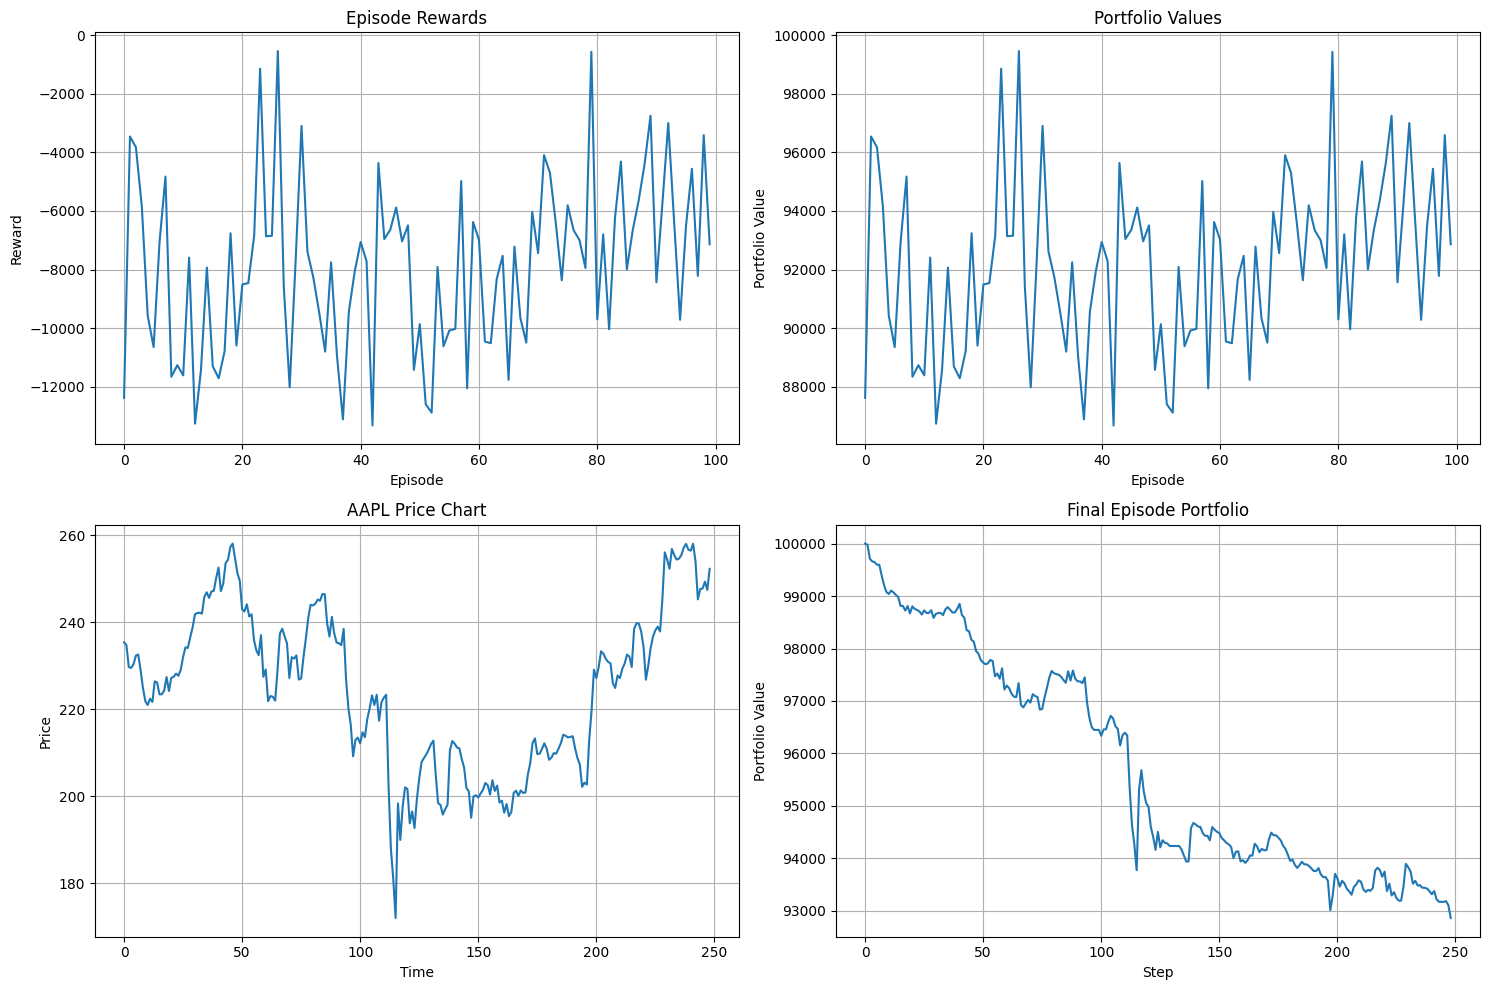


Final Results:
Initial Portfolio: $100,000.00
Final Portfolio: $92,864.87
Return: -7.14%


In [56]:
# Plot training results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Episode rewards
axes[0, 0].plot(episode_rewards)
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(True)

# Portfolio values
axes[0, 1].plot(episode_portfolios)
axes[0, 1].set_title('Portfolio Values')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Portfolio Value')
axes[0, 1].grid(True)

# Price chart with final episode
axes[1, 0].plot(data['Close'].values)
axes[1, 0].set_title(f'{ticker} Price Chart')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Price')
axes[1, 0].grid(True)

# Portfolio progression for last episode
axes[1, 1].plot(env.portfolio_values)
axes[1, 1].set_title('Final Episode Portfolio')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Portfolio Value')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print final results
initial_value = env.initial_balance
final_value = env.portfolio_values[-1]
return_pct = (final_value - initial_value) / initial_value * 100

print(f"\nFinal Results:")
print(f"Initial Portfolio: ${initial_value:,.2f}")
print(f"Final Portfolio: ${final_value:,.2f}")
print(f"Return: {return_pct:.2f}%")


## 9. TensorBoard

Run this in a separate terminal to view training metrics:
```bash
tensorboard --logdir=runs --port=6006
```

Then open http://localhost:6006 in your browser.


## 10. Quick Test

Run this cell to test if everything is working correctly:


In [57]:
# Quick test to verify everything works
print("Testing DRQN model...")

# Test model
model = DRQN(state_size=14, action_size=3)
test_input = torch.randn(1, 1, 14)  # (batch_size=1, seq_len=1, state_size=14)
output = model(test_input)
print(f"Model output shape: {output.shape}")
print(f"Model output: {output}")

# Test environment
env = TradingEnvironment(data)
state = env.reset()
print(f"Environment state shape: {state.shape}")
print(f"Environment state: {state}")

# Test agent
agent = DRQNAgent()
action = agent.act(state)
print(f"Agent action: {action}")

print("✅ All tests passed! The notebook is ready to use.")


Testing DRQN model...
Model output shape: torch.Size([1, 3])
Model output: tensor([[-0.0458,  0.0265,  0.0356]], grad_fn=<AddmmBackward0>)
Environment state shape: (14,)
Environment state: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Agent action: 0
✅ All tests passed! The notebook is ready to use.


## Debug: Check Data Structure


In [58]:
# Debug: Check the data structure
print("Data columns:", data.columns.tolist())
print("Data index type:", type(data.index))
print("First few rows:")
print(data.head())

# Try to access Close column
try:
    print("Close column exists:", 'Close' in data.columns)
    print("Sample Close values:", data['Close'].head())
except Exception as e:
    print("Error accessing Close:", e)
    print("Available columns:", data.columns.tolist())


Data columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First few rows:
Price            Close        High         Low        Open    Volume
Date                                                                
2024-10-21  235.384506  235.752803  233.363911  233.363911  36254500
2024-10-22  234.767395  235.125728  231.522502  232.806520  38846600
2024-10-23  229.691010  234.050724  226.704907  232.995637  52287000
2024-10-24  229.501877  229.750719  227.351880  228.914599  31109500
2024-10-25  230.337997  232.139610  228.506525  228.675736  38802300
Close column exists: True
Sample Close values: Date
2024-10-21    235.384506
2024-10-22    234.767395
2024-10-23    229.691010
2024-10-24    229.501877
2024-10-25    230.337997
Name: Close, dtype: float64


In [59]:
# Test data access
print("Testing data access:")
print("Close column exists:", 'Close' in data.columns)
print("Volume column exists:", 'Volume' in data.columns)
print("Sample Close value:", data['Close'].iloc[0])
print("Sample Volume value:", data['Volume'].iloc[0])


Testing data access:
Close column exists: True
Volume column exists: True
Sample Close value: 235.38450622558594
Sample Volume value: 36254500
